In [1]:
import msprime, tskit
import numpy as np
from IPython.display import display, SVG

# Questions:

1. How can we reduce the number of edges in a tree sequence?
2. Is the equivalent tree sequence with minimal edges unique?
3. How can we be guaranteed to find a tree sequence with minimal edges?

# Simulate a tree sequence

We'll use `msprime` to simulate a very small example: the history of 3 diploids (six genomes)
along a genome of 50bp in a population of size 100 (diploids).
With this random seed we get four different trees; in general the expected number of trees
is roughly four times the sequence length times the recombination rate times the population size.

In [2]:
ts = msprime.sim_ancestry(3, sequence_length=50, recombination_rate=1e-4, random_seed=6, population_size=100)
ts

We can draw the trees:

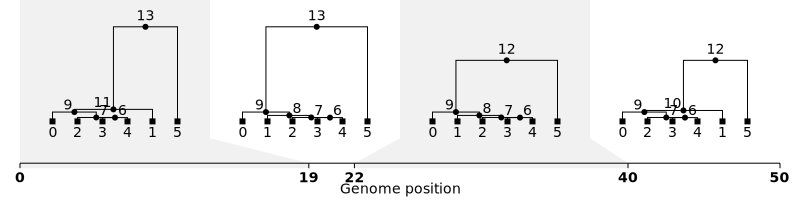

In [3]:
SVG(ts.draw_svg())

The tree sequence is immutable,
so to change things we extract the underlying tables and edit them.
There's a number of tables we won't worry about,
we're only interested in the `node` and `edge` tables:

In [3]:
t = ts.dump_tables()
print(t.nodes)

╔══╤═════╤══════════╤══════════╤════════════╤════════╗
║id│flags│population│individual│time        │metadata║
╠══╪═════╪══════════╪══════════╪════════════╪════════╣
║0 │    1│         0│         0│  0.00000000│     b''║
║1 │    1│         0│         0│  0.00000000│     b''║
║2 │    1│         0│         1│  0.00000000│     b''║
║3 │    1│         0│         1│  0.00000000│     b''║
║4 │    1│         0│         2│  0.00000000│     b''║
║5 │    1│         0│         2│  0.00000000│     b''║
║6 │    0│         0│        -1│ 39.28648696│     b''║
║7 │    0│         0│        -1│ 40.61472407│     b''║
║8 │    0│         0│        -1│ 61.87739822│     b''║
║9 │    0│         0│        -1│ 96.76071699│     b''║
║10│    0│         0│        -1│113.23592655│     b''║
║11│    0│         0│        -1│124.51238281│     b''║
║12│    0│         0│        -1│632.28043141│     b''║
║13│    0│         0│        -1│979.46150023│     b''║
╚══╧═════╧══════════╧══════════╧════════════╧════════╝



In [5]:
print(t.edges)

╔══╤═══════════╤═══════════╤══════╤═════╤════════╗
║id│left       │right      │parent│child│metadata║
╠══╪═══════════╪═══════════╪══════╪═════╪════════╣
║0 │ 0.00000000│50.00000000│     6│    3│     b''║
║1 │ 0.00000000│50.00000000│     6│    4│     b''║
║2 │ 0.00000000│50.00000000│     7│    2│     b''║
║3 │ 0.00000000│50.00000000│     7│    6│     b''║
║4 │19.00000000│40.00000000│     8│    1│     b''║
║5 │19.00000000│40.00000000│     8│    7│     b''║
║6 │ 0.00000000│50.00000000│     9│    0│     b''║
║7 │ 0.00000000│19.00000000│     9│    7│     b''║
║8 │40.00000000│50.00000000│     9│    7│     b''║
║9 │19.00000000│40.00000000│     9│    8│     b''║
║10│40.00000000│50.00000000│    10│    1│     b''║
║11│40.00000000│50.00000000│    10│    9│     b''║
║12│ 0.00000000│19.00000000│    11│    1│     b''║
║13│ 0.00000000│19.00000000│    11│    9│     b''║
║14│22.00000000│50.00000000│    12│    5│     b''║
║15│22.00000000│40.00000000│    12│    9│     b''║
║16│40.00000000│50.00000000│   

## Editing tables

Suppose we wanted to add a new ancestor of nodes 12 and 13 at some long time ago.
To do this we just need to add the node, and these two edges:

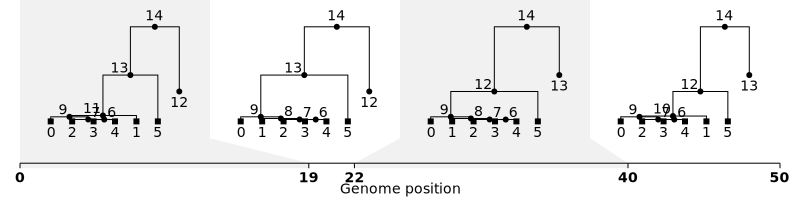

In [6]:
new_id = t.nodes.add_row(time=2000)
for j in [12, 13]:
    t.edges.add_row(parent=new_id, child=j, left=0, right=t.sequence_length)
    
new_ts = t.tree_sequence()
SVG(new_ts.draw_svg())

More often we edit tables by starting a brand-new set of tables and copying the information in.
Suppose we wanted to remove node 5 entirely:

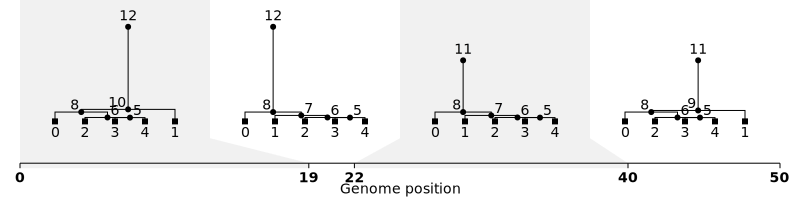

In [7]:
t = tskit.TableCollection(sequence_length=t.sequence_length)
for n in ts.nodes():
    if n.id != 5:
        t.nodes.add_row(time=n.time, flags=n.flags)
        
# must remap nodes
def map_node(n):
    return n if n < 5 else n-1
        

for e in ts.edges():
    if e.child != 5 and e.parent != 5:
        t.edges.add_row(
            parent=map_node(e.parent),
            child=map_node(e.child),
            left=e.left,
            right=e.right
        )

new_ts = t.tree_sequence()
SVG(new_ts.draw_svg())

Note the the nodes have been re-numbered. (If we wanted to retain the old IDs,
we could store them in metadata.)

# Quick reference

- general tutorials: https://tskit.dev/tutorials/intro.html
- ways to modify the Node table: https://tskit.dev/tskit/docs/stable/python-api.html#tskit.NodeTable
- ways to visualize trees: https://tskit.dev/tutorials/viz.html
- msprime quickstart: https://tskit.dev/msprime/docs/stable/quickstart.html

# First pass

This works, but doesn't find all possible reductions (consider if an edge is subdivided in more than two pieces).

In [10]:
new_left = t.edges.left
new_right = t.edges.right
keep = np.repeat(True, t.edges.num_rows)
for i1, e1 in enumerate(t.edges):
    for i2, e2 in enumerate(t.edges):
        if i1 != i2:
            if e1.parent == e2.parent:
                for i3, e3 in enumerate(t.edges):
                    if i1 != i3 and i2 != i3:
                        if e1.child == e3.child and e2.child == e3.parent:
                            if e1.right == e2.left and e2.left == e3.left:
                                # extend to the left
                                new_left[i2] = e1.left
                                new_left[i3] = e1.left
                                keep[i1] = False
                            if e1.left == e2.right and e2.right == e3.right:
                                # extend to the right
                                new_right[i2] = e1.right
                                new_right[i3] = e1.right
                                keep[i1] = False

new_t = t.copy()
new_t.edges.clear()
for j, (k, e) in enumerate(zip(keep, t.edges)):
    if k:
        new_t.edges.add_row(parent=e.parent, child=e.child, left=new_left[j], right=new_right[j])
        
new_ts = new_t.tree_sequence()
print(f"Old number of edges: {t.edges.num_rows}")
print(f"New number of edges: {new_t.edges.num_rows}")

Old number of edges: 20
New number of edges: 16


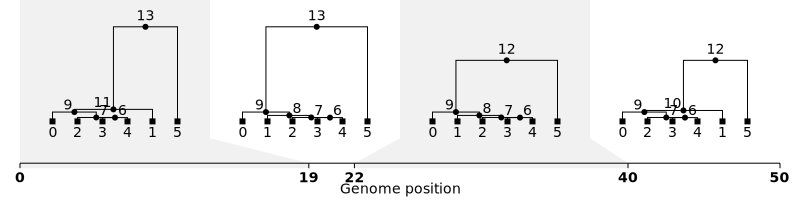

In [12]:
SVG(ts.draw_svg())

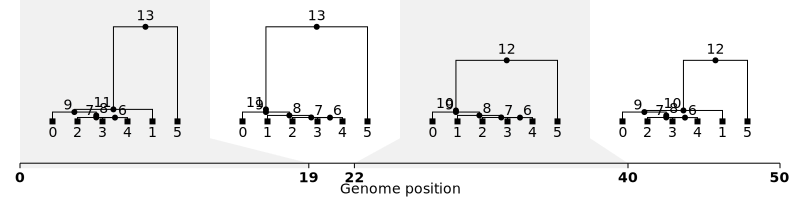

In [13]:
SVG(new_ts.draw_svg())